In [5]:
import pandas as pd
from plotnine import *
from datetime import datetime
import numpy as np

In [6]:
or_events = pd.read_parquet('./outage_report_2019-20')
or_reports = pd.read_parquet('./outage_report_individual_reports_2019-20')

In [7]:
filtered_or_events = or_events[(or_events['vendor'] != '') & (or_events['vendor'] != 'overview')].copy()
filtered_or_events = filtered_or_events.drop_duplicates(subset=['vendor', 'event_time', 'status_code'])
# Combine events with the same event_time, but different status_code with max
filtered_or_events = filtered_or_events.groupby(['vendor', 'event_time'])['status_code'].max().reset_index()

In [8]:
filtered_or_reports = or_reports[(or_reports['reason'] != '') & (or_reports['vendor'] != 'overview')].reset_index(drop=True)

In [9]:
thresholded_or_events = filtered_or_events[filtered_or_events['status_code'] > 2].copy()

In [11]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Apple-servers', 'Facebook-messenger', 'Youtube'], ['Apple', 'FB Msgr', 'YouTube'])

filtered_or_reports['vendor_proper'] = proper_vendor_names(filtered_or_reports['vendor'])

In [12]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Apple-servers', 'Facebook-messenger', 'Youtube'], ['Apple', 'FB Msgr', 'YouTube'])

filtered_or_events['vendor_proper'] = proper_vendor_names(filtered_or_events['vendor'])

In [13]:
vendor_list = list(filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'}).sort_values('count')['vendor_proper'])
vendor_list

['Apple',
 'Github',
 'Skype',
 'FB Msgr',
 'Gmail',
 'Whatsapp',
 'Snapchat',
 'Netflix',
 'Facebook',
 'Twitter',
 'YouTube',
 'Instagram']

In [28]:
event_count_df = filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'})
report_count_df = filtered_or_reports.groupby('vendor_proper')['country'].count().reset_index().rename(columns={'country':'count'}).set_index('vendor_proper')

joined_count_df = event_count_df.join(report_count_df, on='vendor_proper', lsuffix='_events', rsuffix='_reports')
joined_count_df['prop'] = (joined_count_df['count_reports'] / joined_count_df['count_events']) * 100
joined_count_df['count_events'] = joined_count_df['count_events'].astype(int)

print(joined_count_df.sort_values('count_events').to_latex(index=None, float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
vendor\_proper &  count\_events &  count\_reports &  prop \\
\midrule
        Apple &          3208 &           2566 & 79.99 \\
       Github &          4432 &           1062 & 23.96 \\
        Skype &          4799 &           2029 & 42.28 \\
      FB Msgr &         13788 &           6836 & 49.58 \\
        Gmail &         16471 &           9427 & 57.23 \\
     Whatsapp &         34653 &           9426 & 27.20 \\
     Snapchat &         68863 &           8118 & 11.79 \\
      Netflix &         74631 &          20211 & 27.08 \\
     Facebook &         79880 &          25886 & 32.41 \\
      Twitter &        136672 &          20252 & 14.82 \\
      YouTube &        152169 &          26783 & 17.60 \\
    Instagram &        193687 &          41574 & 21.46 \\
\bottomrule
\end{tabular}



In [29]:
#
print(joined_count_df['count_events'].sum())
print(joined_count_df['count_reports'].sum())
print(joined_count_df['count_reports'].sum() / joined_count_df['count_events'].sum())

783253
174170
0.22236748534636958


In [34]:
filtered_or_events['evtime'] = pd.to_datetime(filtered_or_events['event_time'], unit='s')
filtered_or_events['hour_of_week'] = filtered_or_events['evtime'].dt.dayofweek * 24 + (filtered_or_events['evtime'].dt.hour + 1)
filtered_or_events['week_of_year'] = filtered_or_events['evtime'].dt.weekofyear

<ipython-input-34-de7f15117fb8>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [33]:
# First and last dates in the dataset
print(filtered_or_events['evtime'].min())
print(filtered_or_events['evtime'].max())

2019-04-14 11:20:00
2020-10-31 23:00:00


In [35]:
grouped_df_list = []
for vendor in filtered_or_events['vendor_proper'].unique():
    vendor_df = filtered_or_events[filtered_or_events['vendor_proper'] == vendor].copy()
    partial_grouped_df = vendor_df.groupby('hour_of_week')['status_code'].sum().reset_index().rename(columns={'status_code': 'sum'})
    partial_grouped_df['prop'] = partial_grouped_df['sum'] / partial_grouped_df['sum'].max()
    partial_grouped_df['vendor_proper'] = vendor
    grouped_df_list.append(partial_grouped_df)
grouped_df = pd.concat(grouped_df_list)
grouped_df

,hour_of_week,sum,prop,vendor_proper
0,1,19.0,0.142857,Apple
1,2,40.0,0.300752,Apple
2,3,81.0,0.609023,Apple
3,4,124.0,0.932331,Apple
4,5,22.0,0.165414,Apple
...,...,...,...,...
163,164,2431.0,0.413717,YouTube
164,165,1151.0,0.195882,YouTube
165,166,450.0,0.076583,YouTube
166,167,398.0,0.067733,YouTube


/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/or_hour_of_week.pdf


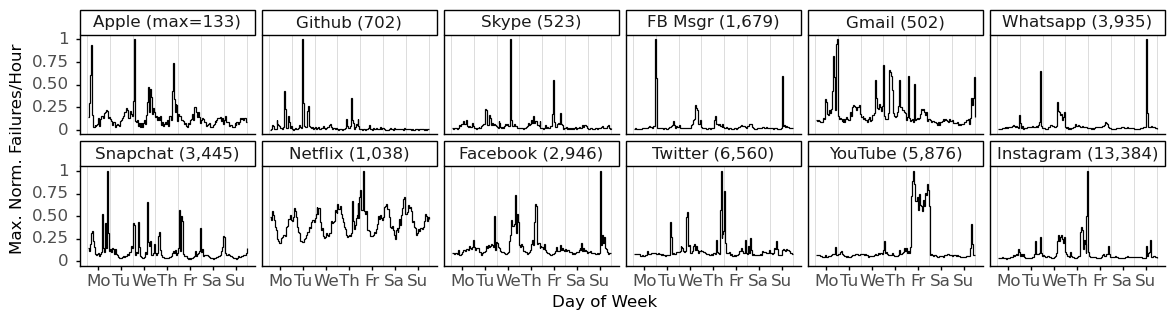

<ggplot: (306119497)>

In [36]:
grouped_df['vendor_cat'] = pd.Categorical(grouped_df['vendor_proper'], categories=vendor_list, ordered=True)

vendor_maxes = grouped_df.groupby('vendor_proper')['sum'].max()

def label_func(vendor):
    if vendor == 'Apple':
        return vendor + ' (max={:,})'.format(int(vendor_maxes.loc[vendor]))
    else:
        return vendor + ' ({:,})'.format(int(vendor_maxes.loc[vendor]))

plt = ggplot(grouped_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_minor_x=element_line(size=0.7, color="gainsboro"),
          panel_grid_major_x=element_blank(),
          text=element_text(size=12)) +\
    geom_step(aes(x="hour_of_week", y="prop")) +\
    facet_wrap(facets='vendor_cat', nrow=2, labeller=label_func) +\
    scale_x_continuous(breaks = [12, 36, 60, 84, 108, 132, 156],
                    labels = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]) +\
    xlab("Day of Week") +\
    ylab("Max. Norm. Failures/Hour")

plt.save('plots/or_hour_of_week.pdf')
plt